### Import Essential Libraries 

In [2]:
import numpy as np
import networkx as nx
from deap import base, creator, tools, algorithms
import random
import folium
import itertools
from scipy.spatial import distance_matrix
from sklearn.cluster import KMeans

### Create Graph 

#### Hotspots are nodes of the graph and weights are assigned to each node based on real distance between hotspots and police station.

We have decided to develop an algorithm based on a particular neighbourhood, Yishun. 
Actual coordinates are used as hotspots (subjected to correct data). 

In [3]:
# Define the coordinates of the hotspots (including the police station)
hotspots = [
    (1.429497255050177, 103.84020473651532),  # Police station coordinates
    (1.4330621251437414, 103.83778167687922),  # Yishun coordinates
    (1.4371190344748281, 103.83539436698997),
    (1.4252566436379683, 103.83590935114745),
    (1.4248276228794505, 103.84286163671058)
]

# Create a graph where nodes are hotspots and edges are Euclidean distances between them
G = nx.complete_graph(len(hotspots))
for i, coord1 in enumerate(hotspots):
    for j, coord2 in enumerate(hotspots):
        if i != j:
            distance = np.linalg.norm(np.array(coord1) - np.array(coord2))
            G[i][j]['weight'] = distance

# Check if the graph is created correctly
print("Graph Nodes:", G.nodes)
print("Graph Edges:", G.edges(data=True))

Graph Nodes: [0, 1, 2, 3, 4]
Graph Edges: [(0, 1, {'weight': 0.004310396360439602}), (0, 2, {'weight': 0.009012833992058149}), (0, 3, {'weight': 0.006035985471143113}), (0, 4, {'weight': 0.005372576966174478}), (1, 2, {'weight': 0.004707203185325589}), (1, 3, {'weight': 0.008026901343781687}), (1, 4, {'weight': 0.009675382133480553}), (2, 3, {'weight': 0.011873564125773988}), (2, 4, {'weight': 0.014381895427490602}), (3, 4, {'weight': 0.006965510272948608})]


### Visualising hotspots of Yishun Neighbourhood at a glance

In [4]:
# Create a Folium map displaying the hotspots in Yishun Neighburhood
map_center = hotspots[0]
mymap = folium.Map(location=map_center, zoom_start=13)

# Add crime hotspots to the map as markers
for i, coord in enumerate(hotspots):
    folium.Marker(location=coord, popup=f"Hotspot {i+1}").add_to(mymap)

# Save or display the map
mymap.save('graph_map.html')
mymap


### Set up Genetic Algorithm

In [5]:
# Determine the starting point (police station)
starting_point = 0

# Genetic Algorithm setup
population_size = 100

# Define the fitness function
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("PatrolPolice", list, fitness=creator.FitnessMin)

# Define the evaluation function
def eval_route(patrol_police):
    distance = 0
    for i in range(len(patrol_police) - 1):
        distance += G[patrol_police[i]][patrol_police[i + 1]]['weight']
    distance += G[patrol_police[-1]][patrol_police[0]]['weight']
    return distance,

# Genetic Algorithm setup
toolbox = base.Toolbox()
toolbox.register("indices", itertools.permutations, range(1, len(hotspots)))
toolbox.register("patrol_police", lambda: [starting_point] + random.sample(range(1, len(hotspots)), len(hotspots) - 1))
toolbox.register("mate", tools.cxPartialyMatched)
toolbox.register("mutate", tools.mutShuffleIndexes, indpb=0.05)
toolbox.register("select", tools.selTournament, tournsize=3)
toolbox.register("evaluate", eval_route)

# Create an initial population
population = [creator.PatrolPolice(toolbox.patrol_police()) for _ in range(population_size)]

# Evaluate the fitness of initial population
fitnesses = list(map(toolbox.evaluate, population))
for ind, fit in zip(population, fitnesses):
    ind.fitness.values = fit
    print("Initial individual:", ind)  # Debug print
    print("Fitness:", fit)  # Debug print

# Ensure graph is correct
print("Number of hotspots:", len(hotspots))  
print("Number of nodes in the graph:", len(G.nodes)) 


Initial individual: [0, 1, 2, 3, 4]
Fitness: (0.03322925091066226,)
Initial individual: [0, 3, 2, 1, 4]
Fitness: (0.037664711881897725,)
Initial individual: [0, 4, 2, 3, 1]
Fitness: (0.04396533422366036,)
Initial individual: [0, 1, 2, 3, 4]
Fitness: (0.03322925091066226,)
Initial individual: [0, 4, 2, 1, 3]
Fitness: (0.03852456239391547,)
Initial individual: [0, 4, 3, 1, 2]
Fitness: (0.03408502576028851,)
Initial individual: [0, 4, 1, 2, 3]
Fitness: (0.03766471188189772,)
Initial individual: [0, 2, 1, 4, 3]
Fitness: (0.03639691505495601,)
Initial individual: [0, 3, 4, 2, 1]
Fitness: (0.036400990717347516,)
Initial individual: [0, 2, 4, 1, 3]
Fitness: (0.0471329983679541,)
Initial individual: [0, 3, 4, 2, 1]
Fitness: (0.036400990717347516,)
Initial individual: [0, 3, 4, 2, 1]
Fitness: (0.036400990717347516,)
Initial individual: [0, 1, 3, 2, 4]
Fitness: (0.043965334223660356,)
Initial individual: [0, 3, 1, 4, 2]
Fitness: (0.04713299836795411,)
Initial individual: [0, 3, 1, 2, 4]
Fitness:

/Users/chloeyeo/anaconda3/lib/python3.11/site-packages/deap/creator.py:185: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/Users/chloeyeo/anaconda3/lib/python3.11/site-packages/deap/creator.py:185: RuntimeWarning: A class named 'PatrolPolice' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


In [6]:
# Evolve the population
algorithms.eaSimple(population, toolbox, cxpb=0.7, mutpb=0.2, ngen=50, verbose=False)

# Get the best route
best_patrol_police = tools.selBest(population, k=1)[0]  
best_route = [hotspots[i] for i in best_patrol_police]


### Visualising Optimal Route 

In [7]:
# Visualize the optimal route with annotations
map_center = [np.mean([coord[0] for coord in hotspots]), np.mean([coord[1] for coord in hotspots])]
mymap = folium.Map(location=map_center, zoom_start=13)

# Add crime hotspots to the map
for i, coord in enumerate(hotspots):
    folium.CircleMarker(location=coord, radius=5, color='red').add_to(mymap)
    folium.Marker(location=coord, icon=folium.Icon(color='green'), popup=f"Hotspot {i+1}").add_to(mymap)  # Add hotspot numbers

# Add the optimal patrol route to the map with annotations
for i in range(len(best_route)):
    coord = best_route[i]
    annotation = '1' if i == 0 else str(i + 1)  # Annotate starting point as '1', others accordingly
    folium.Marker(location=coord, icon=folium.DivIcon(html=f"<div style='font-size: large;'>{annotation}</div>")).add_to(mymap)  # Add visit numbers
    if i < len(best_route) - 1:
        next_coord = best_route[i + 1]
        folium.PolyLine(locations=[coord, next_coord], color='blue', weight=2.5, opacity=1).add_to(mymap)

# Connect the last hotspot to the starting point
folium.PolyLine(locations=[best_route[-1], best_route[0]], color='blue', weight=2.5, opacity=1).add_to(mymap)

# Save or display the map
mymap.save('optimal_patrol_route_with_annotations.html')
mymap

### Create a static map using Matplotlib instead of interactive map using Folium (unavailable for view on Github)

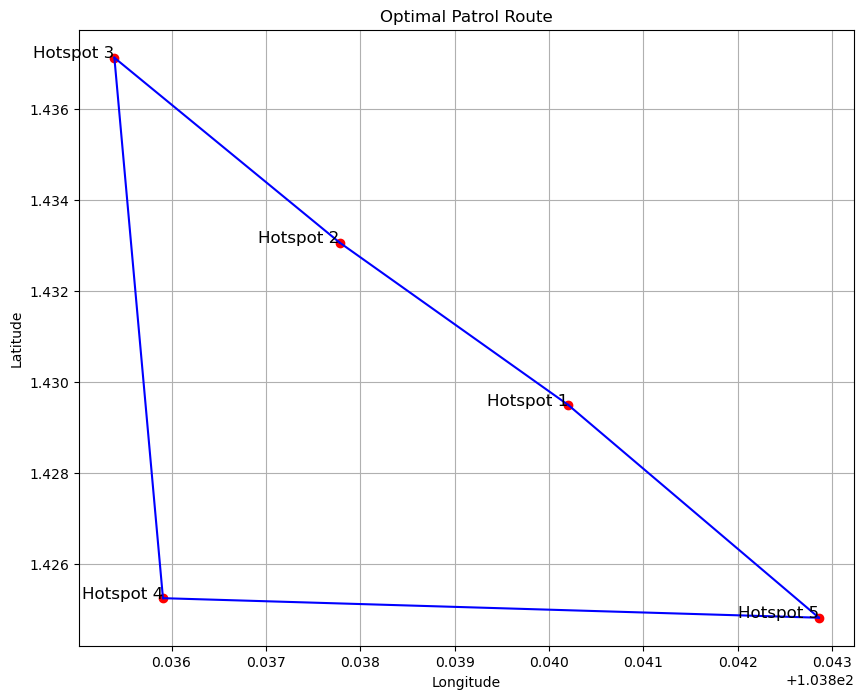

In [8]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 8))
plt.title("Optimal Patrol Route")
plt.xlabel("Longitude")
plt.ylabel("Latitude")

# Plot hotspots
for i, coord in enumerate(hotspots):
    plt.plot(coord[1], coord[0], 'ro')  # Red dot for hotspots
    plt.text(coord[1], coord[0], f"Hotspot {i+1}", fontsize=12, ha='right')

# Plot the optimal patrol route
for i in range(len(best_route) - 1):
    plt.plot([best_route[i][1], best_route[i + 1][1]], [best_route[i][0], best_route[i + 1][0]], 'b-')  # Blue line for route

# Connect the last hotspot to the starting point
plt.plot([best_route[-1][1], best_route[0][1]], [best_route[-1][0], best_route[0][0]], 'b-')  # Blue line for route

plt.grid(True)
plt.show()

## A route is now generated, but no heuristic functions have been implemented yet and the algorithm simply covers all wayspots from a starting point and back to it. Next, we redesign the genetic algorithm. 

With a server that connects all neighbourhood police stations, the software allows for input by respective stations to update their current manpower available and also to monitor activities in their vicinites. 
Since we have no live real-time data, we simulate such situations by randomising crime data and manpower data as these data changes with time. 

In [9]:
# Define the coordinates of the hotspots (including the police station)
hotspots = [
    (1.429497255050177, 103.84020473651532),  # Police station coordinates
    (1.4330621251437414, 103.83778167687922),  # Yishun coordinates
    (1.4371190344748281, 103.83539436698997),
    (1.4252566436379683, 103.83590935114745),
    (1.4248276228794505, 103.84286163671058)
]

# Function to generate random crime data
def generate_random_crime_data(hotspots):
    crime_data = {}
    for i, hotspot in enumerate(hotspots):
        # Generate a random crime severity score between 0 and 10 for each hotspot
        crime_data[i] = random.randint(0, 10)
    return crime_data

# Sample manpower data
def generate_random_manpower_data(hotspots):
    manpower_data = {}
    for i, hotspot in enumerate(hotspots):
        # Generate a random manpower count between 0 and 20 for each hotspot
        manpower_data[i] = random.randint(0, 20)
    return manpower_data

# Generate random crime data
crime_data = generate_random_crime_data(hotspots)
manpower_data = generate_random_manpower_data(hotspots)

### Dynamic Weighting of Hotspots

The function adjust_weights adjusts the weights of the graph's edges, prioritising areas with higher crime rates.

In [10]:
# Function to adjust weights based on crime data
def adjust_weights(graph, crime_data):
    for node in graph.nodes:
        if node in crime_data and crime_data[node] > 0:  # Skip the police station with severity 0
            for neighbor in graph.neighbors(node):
                graph[node][neighbor]['weight'] *= crime_data[node]

# Create a graph where nodes are hotspots and edges are Euclidean distances between them
G = nx.complete_graph(len(hotspots))
distances = distance_matrix(hotspots, hotspots)
for i, coord1 in enumerate(hotspots):
    for j, coord2 in enumerate(hotspots):
        if i != j:
            G[i][j]['weight'] = distances[i, j]

# Adjust weights based on crime data
adjust_weights(G, crime_data)

### Redesign Genetic Algorithm by Adding Manpower Constraints. 

The population size of the genetic algorithm is adjusted based on the available manpower, allowing the algorithm to scale with the number of patrol units.

The fitness function eval_route_multi reconsiders both the total distance and the priority (crime severity) of the hotspots.

In [11]:
# Determine the starting point (police station)
starting_point = 0

# Genetic Algorithm setup
population_size = 300

# Define the fitness function
creator.create("FitnessMulti", base.Fitness, weights=(-1.0, -1.0, -1.0))
creator.create("PatrolPolice", list, fitness=creator.FitnessMulti)

# Function to evaluate route with real-time data
def eval_route_multi(individual, crime_data, manpower_data):
    patrol_police = individual  # Extracting patrol_police from individual

    # Create a copy of the graph to modify weights dynamically
    G_temp = G.copy()

    # Adjust weights based on crime data
    adjust_weights(G_temp, crime_data)

    distance = 0
    priority = 0
    total_manpower = 0
    for i in range(len(patrol_police) - 1):
        distance += G_temp[patrol_police[i]][patrol_police[i + 1]]['weight']
        priority += crime_data.get(patrol_police[i], 0)
        total_manpower += manpower_data.get(patrol_police[i], 0)  # Add manpower from nearby police stations

    # Adjust weight for return to starting point
    distance += G_temp[patrol_police[-1]][patrol_police[0]]['weight']
    priority += crime_data.get(patrol_police[-1], 0)
    total_manpower += manpower_data.get(patrol_police[-1], 0)  # Add manpower from nearby police stations

    return distance, -priority, -total_manpower


toolbox = base.Toolbox()
toolbox.register("indices", itertools.permutations, range(1, len(hotspots)))
toolbox.register("patrol_police", lambda: [starting_point] + random.sample(range(1, len(hotspots)), len(hotspots) - 1))
toolbox.register("mate", tools.cxPartialyMatched)
toolbox.register("mutate", tools.mutShuffleIndexes, indpb=0.05)
toolbox.register("select", tools.selNSGA2)

# Function to generate random individuals
toolbox.register("individual", tools.initIterate, creator.PatrolPolice, toolbox.patrol_police)

# Function to generate random population
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

# Register the evaluation function
toolbox.register("evaluate", eval_route_multi, crime_data=crime_data, manpower_data=manpower_data)

# Create an initial random population
population = toolbox.population(n=population_size)

# Generate random crime data and manpower data
crime_data = generate_random_crime_data(hotspots)
manpower_data = generate_random_manpower_data(hotspots)

# Evaluate the fitness of the initial population
fitnesses = list(map(lambda x: toolbox.evaluate(x, crime_data=crime_data, manpower_data=manpower_data), population))
for ind, fit in zip(population, fitnesses):
    ind.fitness.values = fit
    print("Initial individual:", ind)  # Debug print
    print("Fitness:", fit)  # Debug print

print("Number of hotspots:", len(hotspots))  # Debug

# Evolve the population
algorithms.eaMuPlusLambda(population, toolbox, mu=population_size, lambda_=population_size, cxpb=0.7, mutpb=0.2, ngen=50, verbose=False)

# Get the best route
best_patrol_police = tools.selBest(population, k=1)[0]
best_route = [hotspots[i] for i in best_patrol_police]

/Users/chloeyeo/anaconda3/lib/python3.11/site-packages/deap/creator.py:185: RuntimeWarning: A class named 'PatrolPolice' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


Initial individual: [0, 3, 1, 4, 2]
Fitness: (22.10084192132965, -18, -35)
Initial individual: [0, 3, 2, 1, 4]
Fitness: (17.306779897432087, -18, -35)
Initial individual: [0, 4, 1, 2, 3]
Fitness: (17.306779897432087, -18, -35)
Initial individual: [0, 1, 2, 4, 3]
Fitness: (15.857526597278726, -18, -35)
Initial individual: [0, 3, 1, 2, 4]
Fitness: (19.44021599423904, -18, -35)
Initial individual: [0, 1, 3, 4, 2]
Fitness: (20.382006852339902, -18, -35)
Initial individual: [0, 4, 1, 2, 3]
Fitness: (17.306779897432087, -18, -35)
Initial individual: [0, 4, 2, 1, 3]
Fitness: (19.44021599423904, -18, -35)
Initial individual: [0, 4, 3, 1, 2]
Fitness: (18.895843286967892, -18, -35)
Initial individual: [0, 3, 1, 2, 4]
Fitness: (19.44021599423904, -18, -35)
Initial individual: [0, 3, 2, 4, 1]
Fitness: (18.7929434628041, -18, -35)
Initial individual: [0, 1, 2, 4, 3]
Fitness: (15.857526597278726, -18, -35)
Initial individual: [0, 3, 4, 1, 2]
Fitness: (17.03198895899732, -18, -35)
Initial individual:

### Visualising Map with Optimal Routes

In [12]:
# Visualize the optimal route with annotations
map_center = [np.mean([coord[0] for coord in hotspots]), np.mean([coord[1] for coord in hotspots])]
mymap = folium.Map(location=map_center, zoom_start=13)

# Add crime hotspots to the map
for i, coord in enumerate(hotspots):
    popup_text = "Yishun Neighbourhood Police Station" if i == 0 else f"Hotspot {i}"
    folium.CircleMarker(location=coord, radius=5, color='red').add_to(mymap)
    folium.Marker(location=coord, icon=folium.Icon(color='green'), popup=folium.Popup(popup_text, parse_html=True)).add_to(mymap)  # Add hotspot numbers

# Add the optimal patrol route to the map with annotations
for i in range(len(best_route)):
    coord = best_route[i]
    annotation = '1' if i == 0 else str(i + 1)  # Annotate starting point as '1', others accordingly
    folium.Marker(location=coord, icon=folium.DivIcon(html=f"<div style='font-size: large;'>{annotation}</div>")).add_to(mymap)  # Add visit numbers
    if i < len(best_route) - 1:
        next_coord = best_route[i + 1]
        folium.PolyLine(locations=[coord, next_coord], color='blue', weight=2.5, opacity=1).add_to(mymap)

# Connect the last hotspot to the starting point
folium.PolyLine(locations=[best_route[-1], best_route[0]], color='blue', weight=2.5, opacity=1).add_to(mymap)

# Save or display the map
mymap.save('optimal_patrol_route_with_annotations.html')
mymap

### Static Map 

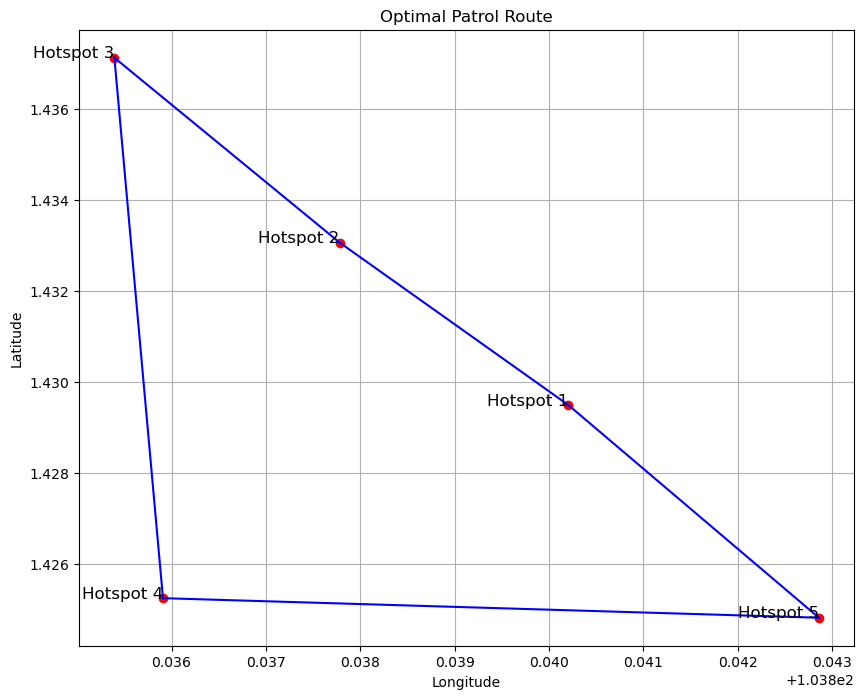

In [13]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 8))
plt.title("Optimal Patrol Route")
plt.xlabel("Longitude")
plt.ylabel("Latitude")

# Plot hotspots
for i, coord in enumerate(hotspots):
    plt.plot(coord[1], coord[0], 'ro')  # Red dot for hotspots
    plt.text(coord[1], coord[0], f"Hotspot {i+1}", fontsize=12, ha='right')

# Plot the optimal patrol route
for i in range(len(best_route) - 1):
    plt.plot([best_route[i][1], best_route[i + 1][1]], [best_route[i][0], best_route[i + 1][0]], 'b-')  # Blue line for route

# Connect the last hotspot to the starting point
plt.plot([best_route[-1][1], best_route[0][1]], [best_route[-1][0], best_route[0][0]], 'b-')  # Blue line for route

plt.grid(True)
plt.show()

### Generated map with optimal route is different from the previous route after adjusting for algorithm to priotise manpower and crime rate.

### Besides finding the optimal patrol route which maximises coverage, another aim is to also shorten emergency response time based on various factors. 
Genetic Algorithm is also used, similarly as above.

In [14]:
# Create a graph where nodes are hotspots and edges are Euclidean distances between them
G = nx.Graph()
for i, coord1 in enumerate(hotspots):
    for j, coord2 in enumerate(hotspots):
        if i != j:
            distance = np.linalg.norm(np.array(coord1) - np.array(coord2))
            G.add_edge(i, j, weight=distance)

# Functions to generate random data
def generate_traffic_data(G):
    traffic_data = {}
    for edge in G.edges():
        # Generate a random traffic multiplier between 0.5 and 1.5
        traffic_multiplier = random.uniform(0.5, 1.5)
        traffic_data[edge] = traffic_multiplier
    return traffic_data

def generate_road_conditions(G):
    road_conditions = {}
    for edge in G.edges():
        # Generate a random road condition score between 0 and 10
        road_condition_score = random.randint(0, 10)
        road_conditions[edge] = road_condition_score
    return road_conditions

def generate_pathway_types(G):
    pathway_types = {}
    for edge in G.edges():
        # Assign numerical values to pathway types
        pathway_type = random.choice(['paved', 'gravel', 'dirt', 'cobblestone'])
        if pathway_type == 'paved':
            pathway_types[edge] = 1.0
        elif pathway_type == 'gravel':
            pathway_types[edge] = 0.8
        elif pathway_type == 'dirt':
            pathway_types[edge] = 0.5
        elif pathway_type == 'cobblestone':
            pathway_types[edge] = 0.9
    return pathway_types


def generate_manpower_data(G, hotspots):
    manpower_data = {}
    for node in G.nodes():
        # Generate a random manpower count between 0 and 20 for each node
        manpower_count = random.randint(0, 20)
        # Add manpower from nearby police stations
        for hotspot_index, hotspot_node in enumerate(hotspots):
            if hotspot_index != node:  # Check against hotspot index instead of hotspot node
                distance = G[node][hotspot_index]['weight']  # Access using hotspot index
                if distance <= 5:  # Consider nearby police stations within a radius of 5 units
                    manpower_count += random.randint(0, 10)  # Add manpower from nearby police station
        manpower_data[node] = manpower_count
    return manpower_data

# Generate random data
traffic_data = generate_traffic_data(G)
road_conditions = generate_road_conditions(G)
pathway_types = generate_pathway_types(G)
manpower_data = generate_manpower_data(G,hotspots)

In [15]:
# Determine the starting point for emergency response
starting_point_emergency = hotspots.index((1.429497255050177, 103.84020473651532))  # Index of the police station in the list of hotspots

# Define the coordinates of the emergency rescue destination
emergency_destination = (1.4309153535796482, 103.83721137977923)  

def calculate_distance(point1, point2):
    return np.linalg.norm(np.array(point1) - np.array(point2))

def calculate_time(point1, point2, traffic_data, road_conditions, pathway_types):
    # Default speed in kilometers per hour
    default_speed = 50.0
    
    # Calculate the distance between the two points
    distance = calculate_distance(point1, point2)
    
    # Adjust speed based on road conditions and pathway types
    speed_factor = 1.0
    road_condition = road_conditions.get((point1, point2), 5.0)  # Default road condition score
    pathway_type = pathway_types.get((point1, point2), 'paved')  # Default pathway type
    if pathway_type == 'paved':
        speed_factor *= 1.1  # Assume paved roads are faster
    elif pathway_type == 'gravel':
        speed_factor *= 0.9  # Assume gravel roads are slower
    elif pathway_type == 'dirt':
        speed_factor *= 0.8  # Assume dirt roads are even slower
    elif pathway_type == 'cobblestone':
        speed_factor *= 0.7  # Assume cobblestone roads are slowest
    
    # Adjust speed based on traffic conditions
    traffic_multiplier = traffic_data.get((point1, point2), 1.0)  # Default traffic multiplier
    speed_factor *= traffic_multiplier
    
    # Calculate time (in hours) to travel between the two points
    time = distance / (default_speed * speed_factor)
    
    return time

def eval_route_emergency(individual, traffic_data, road_conditions, pathway_types, manpower_data):
    total_travel_time = 0
    for i in range(len(individual) - 1):
        # Calculate the weighted sum of factors influencing travel time
        edge_weight = G[individual[i]][individual[i + 1]]['weight']
        
        # Adjust the edge weight based on traffic data, road conditions, and pathway types
        edge_weight *= traffic_data.get((individual[i], individual[i + 1]), 1.0)  # Adjust based on traffic data
        edge_weight *= road_conditions.get((individual[i], individual[i + 1]), 1.0)  # Adjust based on road conditions
        edge_weight *= pathway_types.get((individual[i], individual[i + 1]), 1.0)  # Adjust based on pathway type
        
        total_travel_time += edge_weight
    
    # Calculate travel time from last node to emergency destination
    last_node = individual[-1]
    distance_to_destination = calculate_distance(hotspots[last_node], emergency_destination)
    travel_time_to_destination = calculate_time(hotspots[last_node], emergency_destination, traffic_data, road_conditions, pathway_types) # Changed here
    total_travel_time += travel_time_to_destination
    
    # Adjust for manpower of nearby police stations
    for node in individual:
        total_travel_time -= manpower_data.get(node, 0)  # Subtract travel time based on manpower
        
    # Define other objectives (road conditions and pathway types)
    road_condition_score = sum(road_conditions.get((individual[i], individual[i + 1]), 0) for i in range(len(individual) - 1))
    pathway_type_score = sum(pathway_types.get((individual[i], individual[i + 1]), 0) for i in range(len(individual) - 1))
    
    # Return a tuple with three objectives
    return (-total_travel_time, road_condition_score, pathway_type_score)



# Genetic Algorithm setup for emergency response
population_size_emergency = 300

# Define the fitness function for emergency response
creator.create("FitnessMultiEmergency", base.Fitness, weights=(-1.0, -1.0, -1.0))
creator.create("EmergencyResponse", list, fitness=creator.FitnessMultiEmergency)

toolbox_emergency = base.Toolbox()
toolbox_emergency.register("indices", itertools.permutations, range(1, len(hotspots)))
toolbox_emergency.register("emergency_route", lambda: [starting_point_emergency] + random.sample(range(1, len(hotspots)), len(hotspots) - 1))
toolbox_emergency.register("mate", tools.cxPartialyMatched)
toolbox_emergency.register("mutate", tools.mutShuffleIndexes, indpb=0.05)
toolbox_emergency.register("select", tools.selNSGA2)

# Function to generate random individuals for emergency response
toolbox_emergency.register("individual", tools.initIterate, creator.EmergencyResponse, toolbox_emergency.emergency_route)
toolbox_emergency.register("population", tools.initRepeat, list, toolbox_emergency.individual)
toolbox_emergency.register("evaluate", eval_route_emergency, traffic_data=traffic_data, road_conditions=road_conditions, pathway_types=pathway_types, manpower_data=manpower_data)

# Create an initial random population for emergency response
population_emergency = toolbox_emergency.population(n=population_size_emergency)

# Evaluate the fitness of the initial emergency response population
fitnesses_emergency = list(map(lambda x: toolbox_emergency.evaluate(x, traffic_data=traffic_data, road_conditions=road_conditions, pathway_types=pathway_types, manpower_data=manpower_data), population_emergency))
for ind, fit in zip(population_emergency, fitnesses_emergency):
    ind.fitness.values = fit

# Evolve the emergency response population
algorithms.eaMuPlusLambda(population_emergency, toolbox_emergency, mu=population_size_emergency, lambda_=population_size_emergency, cxpb=0.7, mutpb=0.2, ngen=50, verbose=False)

# Get the best emergency response route
best_emergency_response = tools.selBest(population_emergency, k=1)[0]
best_route_emergency = [hotspots[i] for i in best_emergency_response]


In [16]:

# Visualize the route from the police station to the emergency destination
mymap = folium.Map(location=hotspots[0], zoom_start=13)

# Add the route from the police station to the emergency destination to the map
folium.PolyLine(locations=[hotspots[0], emergency_destination], color='green', weight=2.5, opacity=1).add_to(mymap)

# Add marker for the police station
folium.Marker(location=hotspots[0], icon=folium.Icon(color='blue'), popup=folium.Popup("Yishun Neighbourhood Police Station", parse_html=True)).add_to(mymap)

# Add marker for the emergency destination
folium.Marker(location=emergency_destination, icon=folium.Icon(color='red'), popup=folium.Popup("Emergency Destination", parse_html=True)).add_to(mymap)

# Save or display the map
mymap.save('emergency_response_route.html')
mymap
